In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

In [2]:
%load_ext cython

In [3]:
L = 5000
N = 15
drop = 5000
calc = 10000

In [4]:
def analyze(evolve, drop, calc, N, L, begin, end, n):
    all_d = []
    for p in np.linspace(.01, .9, 10):
        np.random.seed(42)
        _field_ = np.random.choice((0, 1), (N, L), p=(1-p, p))
        densities = []
        for b in tqdm(np.linspace(begin, end, n), total=n):
            d = []
            for i in range(N):
                dens = 0
                field = _field_[i].copy()
                field = evolve(field, b, drop)
                for _ in range(calc-drop):
                    field = evolve(field, b)
                    dens += field.sum()/(1.*L)
                dens = dens/(calc-drop)
                d.append(dens)
            densities.append(d)
        all_d.append(densities)
    return np.asarray(all_d)

In [5]:
def mean_wo_zeros(densities, L):
    result = []
    assert densities.ndim == 3
    for dens in densities:
        res = []
        for d in dens:
            if (d < 1/(2.*L)).all():
                res.append(0.)
            else:
                res.append(d[d > 1/(2.*L)].mean())
        result.append(res)
    return np.asarray(result)


def std_wo_zeros(densities, L):
    result = []
    assert densities.ndim == 3
    for dens in densities:
        res = []
        for d in dens:
            if (d < 1/(2.*L)).all():
                res.append(0.)
            else:
                res.append(d[d > 1/(2.*L)].std())
        result.append(res)
    return np.asarray(result)

# Новак-Мэй

In [6]:
begin = .9
end = 3
n = 20

In [4]:
%%cython

import numpy as np

import cython
@cython.cdivision(True)
@cython.boundscheck(False)
def evolve_nm(long[:] field, double b, int num_steps=1):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        
        for x in range(L):
            for i in range(-1, 2):
                ix = (x + i) % L
                scores[x] += field[ix]
            
            if field[x] == 0:
                scores[x] *= b
        
        for x in range(L):
            bestX = x
            for i in range(-1, 2):
                ix = (x + i) % L
                if (scores[bestX] < scores[ix]):
                    bestX = ix

            field[x] = current[bestX]
    return np.asarray(field)

@cython.cdivision(True)
@cython.boundscheck(False)
def score_nm(long[:] field, double b):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()

    for x in range(L):
        for i in range(-1, 2):
            ix = (x + i) % L
            scores[x] += field[ix]

        if field[x] == 0:
            scores[x] *= b

    return np.asarray(scores)

In [8]:
try:
    densities = np.load("nm1d.npy")
except FileNotFoundError:
    densities = analyze(evolve_nm, drop, calc, N, L, begin, end, n)
    np.save("nm1d.npy", densities)

In [9]:
dens = mean_wo_zeros(densities, L)
std = std_wo_zeros(densities, L)

<IPython.core.display.Javascript object>


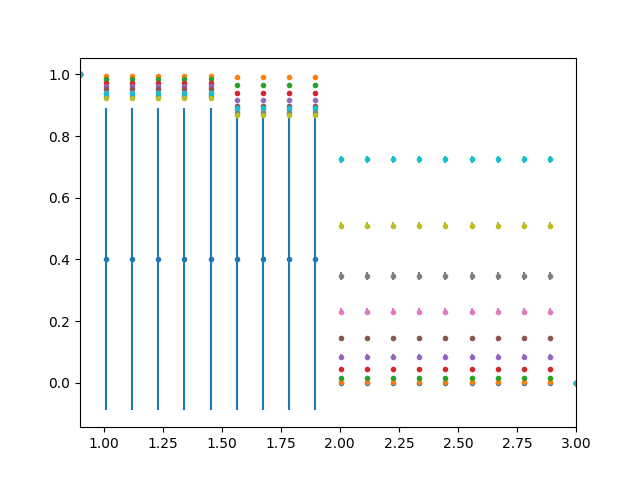

In [10]:
# fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), densities[i].mean(axis=-1), yerr=densities[i].std(axis=-1), fmt=".")
# plt.show()

### Убраны реализации, которые уходят в 0

<IPython.core.display.Javascript object>


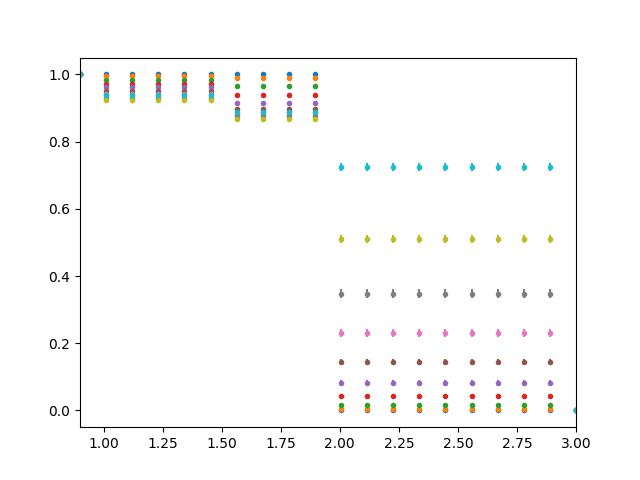

In [11]:
fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt=".")
plt.show()

<IPython.core.display.Javascript object>


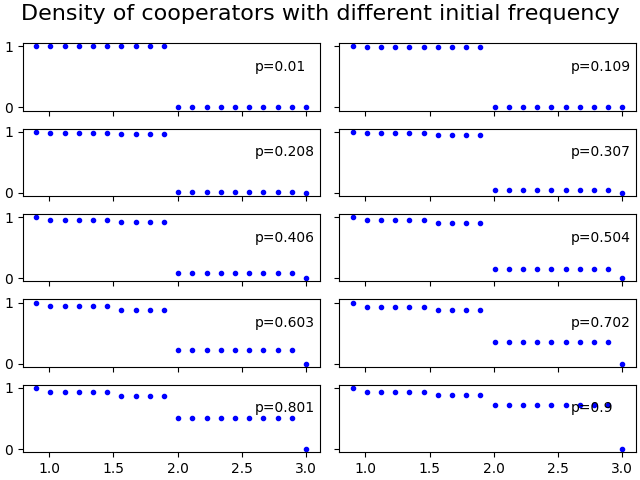

In [12]:
fig, axs = plt.subplots(5, 2, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different initial frequency', fontsize=16)
for i, p in enumerate(np.linspace(.01, .9, 10)):
    axs[i//2, i%2].errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt="b.")
    axs[i//2, i % 2].text(end-.4, 0.6, "p={:.3}".format(p, fontsize=11))

plt.show()

# Среднее поле

In [13]:
begin = .9
end = 2
n = 20

In [5]:
%%cython

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
def ssum(long[:] array, long L):
    
    cdef long s = 0
    
    for i in range(L):
        s += array[i]
    return s

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve_mean(long[:] field, double b, int num_steps=1):
    
    cdef:
        int x, y, L, i, j, ix, jy, step
        double density
    
    L = field.shape[0]
    cdef double[:] scores = np.zeros((L), dtype=float)
    
    cdef double[:] _zeros = np.zeros((L), dtype=float)
    cdef long[:] current = field.copy()
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
        density = ssum(field, L)/(1.*L)
        
        for x in range(L):
            for i in range(-1, 2, 2):
                ix = (x + i) % L
                scores[x] += field[ix]
            
            scores[x] += density
            if field[x] == 0:
                scores[x] *= b
        
        for x in range(L):
            bestX = x
            for i in range(-1, 2, 2):
                ix = (x + i) % L
                if (scores[bestX] < scores[ix]):
                    bestX = ix

            field[x] = current[bestX]
    return np.asarray(field)

In [15]:
try:
    densities = np.load("mean1d.npy")
except FileNotFoundError:
    densities = analyze(evolve_mean, drop, calc, N, L, begin, end, n)
    np.save("mean1d.npy", densities)

In [16]:
f_cs = np.linspace(0, 1, 20)

def trans_val(f_c, m, n, i):
    return (m+i+f_c)/(n+i+f_c)

trans = []

for m in range(2):
    for j in range(2):
        for i in range(2):
            trans.append(trans_val(f_cs, m, j, i))

trans = np.asarray(trans)

/home/admitri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/admitri/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [17]:
dens = mean_wo_zeros(densities, L)
std = std_wo_zeros(densities, L)

<IPython.core.display.Javascript object>


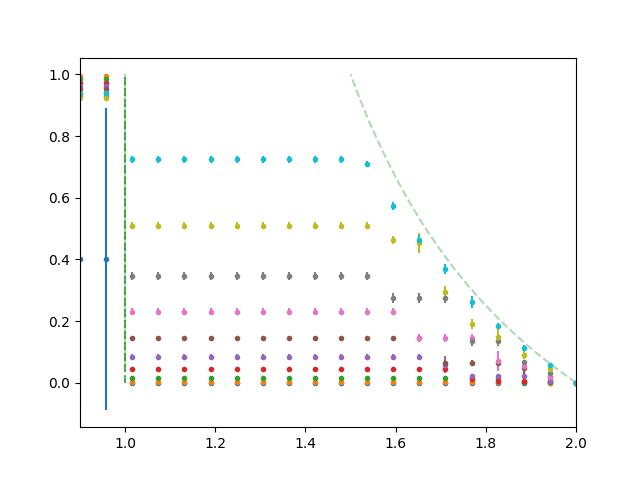

In [18]:
fig  = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), densities[i].mean(axis=-1), yerr=densities[i].std(axis=-1), fmt=".")
for tr in trans:
    plt.plot(tr, f_cs, "g--", alpha=.3)
plt.show()

### Убраны реализации, которые уходят в 0

<IPython.core.display.Javascript object>


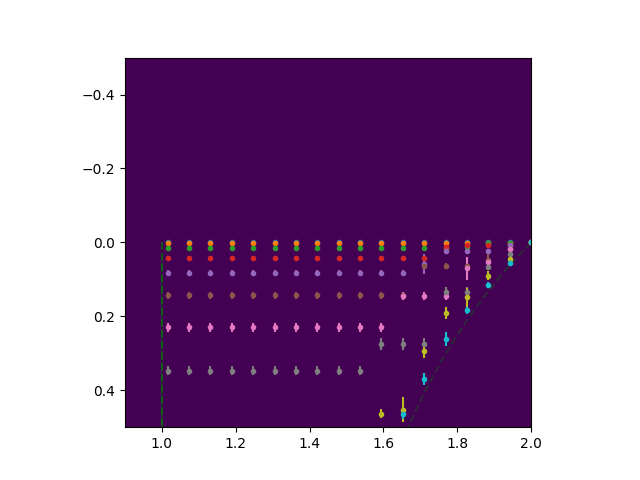

In [19]:
fig = plt.figure()
plt.xlim(begin, end)
for i in range(10):
    plt.errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt=".")
for tr in trans:
    plt.plot(tr, f_cs, "g--", alpha=.3)
plt.show()

<IPython.core.display.Javascript object>


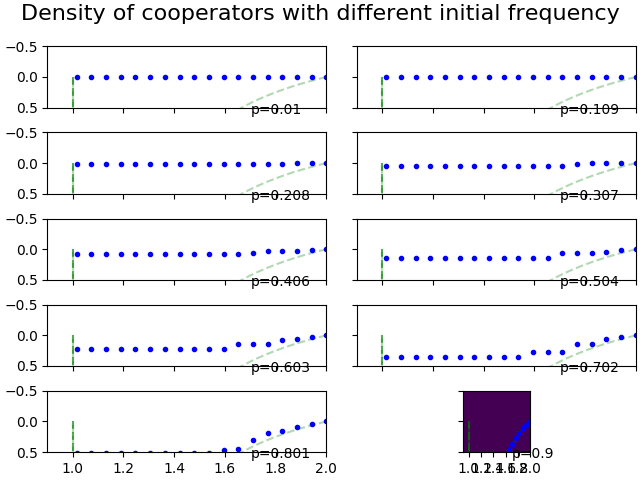

In [20]:
fig, axs = plt.subplots(5, 2, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different initial frequency', fontsize=16)
for i, p in enumerate(np.linspace(.01, .9, 10)):
    plt.xlim(begin, end)
    axs[i//2, i%2].errorbar(np.linspace(begin, end, n), dens[i], yerr=std[i], fmt="b.")
    for tr in trans:
        axs[i//2, i % 2].plot(tr, f_cs, "g--", alpha=.3)
    axs[i//2, i % 2].text(end-.3, 0.6, "p={:.3}".format(p, fontsize=11))

plt.show()

# Анимации

<IPython.core.display.Javascript object>


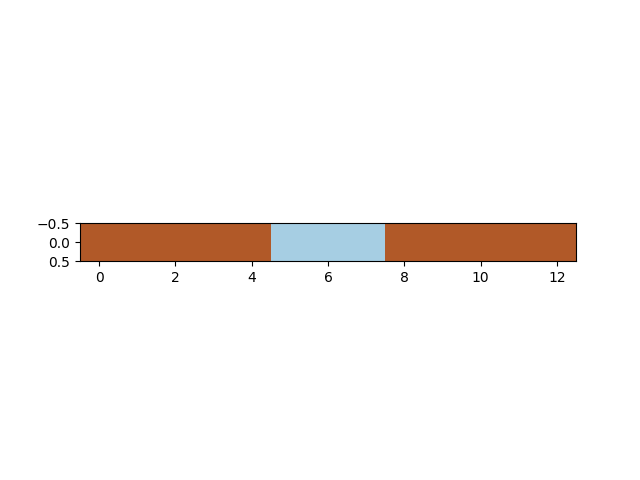

In [89]:
p = .6
L = 100
b = 2.1
# field = np.random.choice((0, 1), L, p=(1-p, p))
field = np.array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int)

fig = plt.figure()
im = plt.imshow(field.reshape([1, -1]), animated=True, cmap=plt.get_cmap('Paired'))
# ax.grid(False)
def updatefig(frame):
    if frame < 3:
        return im,
    global field
    field = evolve_nm(field, b, 1)
    im.set_array(field.reshape([1, -1]))
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=1000, interval=150, blit=True)

In [47]:
clust_sizes = np.asarray([1, 1]*12 + [2, 1])
field = np.array([], dtype=int)
for i, s in enumerate(clust_sizes):
    if i%2 == 0:
        field = np.concatenate((field, np.zeros(s, dtype=int)))
    else:
        field = np.concatenate((field, np.ones(s, dtype=int)))
b = .7
L = field.size
n = (clust_sizes[::2]%2 == 1).sum()
field = evolve_nm(field, b, 5000)
field.sum()/(1.*L)

1.0

## field.sum()/(1.*L)

In [37]:
failed = []
for _ in tqdm(range(100)):
    n_clust = np.random.randint(1, 100)
    clust_sizes = np.random.randint(3, 20, 2*n_clust)
    field = np.array([], dtype=int)
    for i, s in enumerate(clust_sizes):
        if i%2 == 0:
            field = np.concatenate((field, np.zeros(s, dtype=int)))
        else:
            field = np.concatenate((field, np.ones(s, dtype=int)))
    b = 1.3
    L = field.size
    n = (clust_sizes[::2]%2 == 1).sum()
    field = evolve_nm(field, b, 5000)
    for _ in range(10):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if dens != 1 - n/(1.*L):
            failed.append((b, clust_sizes.copy()))
            raise ValueError
            break
    del field, clust_sizes

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


In [49]:
failed = []
for _ in tqdm(range(100)):
    n_clust = np.random.randint(1, 100)
    clust_sizes = np.random.randint(3, 20, 2*n_clust)
    field = np.array([], dtype=int)
    for i, s in enumerate(clust_sizes):
        if i%2 == 0:
            field = np.concatenate((field, np.zeros(s, dtype=int)))
        else:
            field = np.concatenate((field, np.ones(s, dtype=int)))
    b = 1.7
    L = field.size
    n = (clust_sizes[::2]%2 == 1).sum()
    field = evolve_nm(field, b, 5000)
    for _ in range(10):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if dens != 1 - 3*n/(1.*L) or dens >= 1 - n/(1.*L):
            failed.append((b, clust_sizes.copy()))
            raise ValueError
            break
    del field, clust_sizes

  1%|          | 1/100 [00:00<00:29,  3.36it/s]


ValueError: 

In [53]:
evolve_nm(field, b)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
failed = []
for _ in tqdm(range(100)):
    n_clust = np.random.randint(1, 100)
    clust_sizes = np.random.randint(3, 20, 2*n_clust)
    field = np.array([], dtype=int)
    for i, s in enumerate(clust_sizes):
        if i%2 == 0:
            field = np.concatenate((field, np.zeros(s, dtype=int)))
        else:
            field = np.concatenate((field, np.ones(s, dtype=int)))
    b = 2.3
    L = field.size
    dens_0 = field.sum()/L
    field = evolve_nm(field, b, 5000)
    for _ in range(10):
        field = evolve_nm(field, b, 1)
        dens = field.sum()/(1.*L)
        if dens != dens_0:
            failed.append((b, clust_sizes.copy()))
            raise ValueError
            break
    del field, clust_sizes

100%|██████████| 100/100 [00:27<00:00,  3.53it/s]


In [73]:
clust_sizes = failed[0][1]
b = failed[0][0]
field = np.array([], dtype=int)
for i, s in enumerate(clust_sizes):
    if i%2 == 0:
        field = np.concatenate((field, np.zeros(s, dtype=int)))
    else:
        field = np.concatenate((field, np.ones(s, dtype=int)))
L = field.size
n = (clust_sizes[::2]%2 == 1).sum()
# field = evolve_nm(field, b, 5000)

In [67]:
field.sum()/(1.*L)

0.47633136094674555

In [46]:
field = evolve_nm(field, b)

<IPython.core.display.Javascript object>


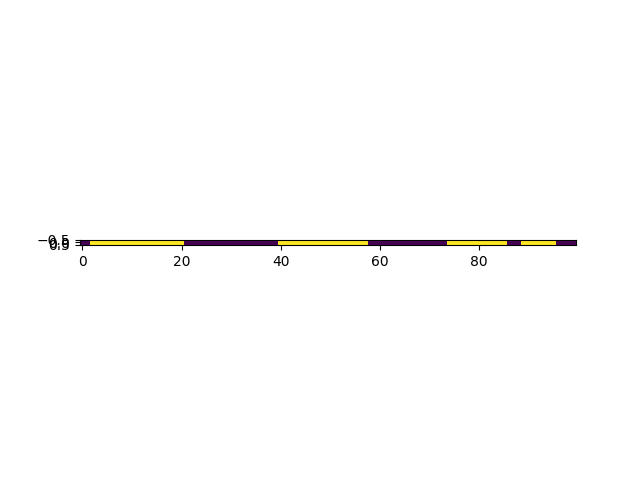

In [76]:
field = evolve_nm(field, b)
plt.imshow(field[100:200].reshape((1, -1)))

In [81]:
field = evolve_nm(field, b, 100)
field[100:200]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [82]:
b

2.28